# Preprocessing


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pydot_ng as pydot
pydot.InvocationException(1)

pydot_ng.InvocationException(1)

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot  as plt
import kerastuner as kt


In [7]:
Stock = pd.read_csv('Dataset/0162.KL.csv')
Stock.head()
display(Stock)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-08-19,0.280,0.285,0.270,0.275,0.275,1157200.0
1,2013-08-20,0.270,0.270,0.250,0.250,0.250,999200.0
2,2013-08-21,0.250,0.255,0.245,0.250,0.250,519000.0
3,2013-08-22,0.240,0.240,0.225,0.240,0.240,1342400.0
4,2013-08-23,0.245,0.255,0.235,0.240,0.240,964000.0
...,...,...,...,...,...,...,...
2462,2023-08-14,0.435,0.435,0.430,0.435,0.435,61125300.0
2463,2023-08-15,0.435,0.440,0.430,0.435,0.435,36496000.0
2464,2023-08-16,0.435,0.435,0.430,0.435,0.435,26590400.0
2465,2023-08-17,0.435,0.440,0.430,0.435,0.435,47587900.0


In [8]:
# Calculation of historical moving averages of closing price (10 and 30 days of trading)
def MA(df, period):
    MA = pd.Series(df['Close'].rolling(period, min_periods=period).mean(), name='MA_' + str(period))
    return MA

Stock['MA10'] = MA(Stock, 10)
Stock['MA30'] = MA(Stock, 30)

#calculation of exponential moving average of closing price (10 and 30 days of trading)
def EMA(df, period):
    EMA = pd.Series(df['Close'].ewm(span=period, min_periods=period).mean(), name='EMA_' + str(period))
    return EMA

Stock['EMA10'] = EMA(Stock, 10)
Stock['EMA30'] = EMA(Stock, 30)


#Calculation of closing price momentum (10 and 30 days of trading)
def MOM(df, period):   
    MOM = pd.Series(df.diff(period), name='Momentum_' + str(period))   
    return MOM

Stock['MOM10'] = MOM(Stock['Close'], 10)
Stock['MOM30'] = MOM(Stock['Close'], 30)

In [9]:
Stock.head(40)

,Date,Open,High,Low,Close,Adj Close,Volume,MA10,MA30,EMA10,EMA30,MOM10,MOM30
0,2013-08-19,0.280,0.285,0.270,0.275,0.275,1157200.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-08-20,0.270,0.270,0.250,0.250,0.250,999200.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-08-21,0.250,0.255,0.245,0.250,0.250,519000.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-08-22,0.240,0.240,0.225,0.240,0.240,1342400.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-08-23,0.245,0.255,0.235,0.240,0.240,964000.0,NaN,NaN,NaN,NaN,NaN,NaN
5,2013-08-26,0.240,0.240,0.225,0.240,0.240,462000.0,NaN,NaN,NaN,NaN,NaN,NaN
6,2013-08-27,0.235,0.235,0.210,0.225,0.225,785100.0,NaN,NaN,NaN,NaN,NaN,NaN
7,2013-08-28,0.220,0.230,0.205,0.230,0.230,1018700.0,NaN,NaN,NaN,NaN,NaN,NaN
8,2013-08-29,0.235,0.240,0.225,0.230,0.230,711000.0,NaN,NaN,NaN,NaN,NaN,NaN
9,2013-08-30,0.225,0.235,0.220,0.235,0.235,274000.0,0.2415,NaN,0.236245,NaN,NaN,NaN


In [10]:
# Creating two columns SMA and LMA to label our dataset
# SMA (Short Moving Average)- The average of the closing price from the next five days in the future
# LMA (Long Moving Average)- The average of the closing price from the last ten days and the next five days in the future

full_data = Stock
full_data['SMA'] = ""
full_data['LMA'] = ""

for ind in range(0, (full_data.shape[0]-5)):
    sma_frame = full_data['Close'].iloc[ind+1:ind+6]
    full_data['SMA'].iloc[ind] = sma_frame.mean()
  
    lma_frame_one = full_data['Close'].iloc[ind-10:ind]
    lma_frame_two = full_data['Close'].iloc[ind+1:ind+6]

    if (lma_frame_one.sum() == 0):
        full_data['LMA'].iloc[ind] = np.NaN
    else: 
        full_data['LMA'].iloc[ind] = (lma_frame_one.sum() + lma_frame_two.sum())/15

full_data['SMA'] = full_data['SMA'].replace('', np.NaN)
full_data['LMA'] = full_data['LMA'].replace('', np.NaN)

#Dropping any empty fields of data
full_data = full_data.dropna(axis=0)
print(full_data.head())

          Date   Open   High    Low  Close  Adj Close    Volume    MA10  \
30  2013-10-01  0.250  0.265  0.245  0.255      0.255  509600.0  0.2440   
31  2013-10-02  0.255  0.260  0.245  0.245      0.245  181500.0  0.2460   
32  2013-10-03  0.245  0.245  0.245  0.245      0.245   70000.0  0.2450   
33  2013-10-04  0.235  0.245  0.230  0.245      0.245  121700.0  0.2445   
34  2013-10-07  0.240  0.245  0.240  0.245      0.245   74200.0  0.2450   

        MA30     EMA10     EMA30  MOM10  MOM30    SMA       LMA  
30  0.236833  0.243722  0.239333  0.025 -0.020  0.244  0.242333  
31  0.236667  0.243955  0.239748  0.020 -0.005  0.243  0.243667  
32  0.236500  0.244145  0.240129 -0.010 -0.005  0.247  0.246333  
33  0.236667  0.244301  0.240479 -0.005  0.005  0.247  0.245667  
34  0.236833  0.244428  0.240802  0.005  0.005  0.248  0.245667  


In [11]:
#Creating target class - Signal
# The signal on a given trading day represents either 1-Buy or 0-Sell 
# The signal is calculated by comparing the future SMA and intermediate LMA
labelled_data = full_data
labelled_data['signal'] = np.where(labelled_data['SMA'] > labelled_data['LMA'], 1.0, 0.0)

#Dropping the SMA and LMA columns to avoid data leakage
labelled_data  = labelled_data.drop(columns = ['SMA', 'LMA'])
print(labelled_data.head(30))

          Date   Open   High    Low  Close  Adj Close     Volume    MA10  \
30  2013-10-01  0.250  0.265  0.245  0.255      0.255   509600.0  0.2440   
31  2013-10-02  0.255  0.260  0.245  0.245      0.245   181500.0  0.2460   
32  2013-10-03  0.245  0.245  0.245  0.245      0.245    70000.0  0.2450   
33  2013-10-04  0.235  0.245  0.230  0.245      0.245   121700.0  0.2445   
34  2013-10-07  0.240  0.245  0.240  0.245      0.245    74200.0  0.2450   
35  2013-10-08  0.240  0.240  0.240  0.240      0.240    51500.0  0.2445   
36  2013-10-09  0.240  0.245  0.235  0.240      0.240   141200.0  0.2445   
37  2013-10-10  0.245  0.275  0.240  0.265      0.265  5534500.0  0.2470   
38  2013-10-11  0.275  0.285  0.235  0.245      0.245  6135700.0  0.2470   
39  2013-10-14  0.240  0.250  0.240  0.250      0.250    35200.0  0.2475   
40  2013-10-16  0.235  0.240  0.235  0.240      0.240   270000.0  0.2460   
41  2013-10-17  0.240  0.245  0.235  0.240      0.240   765500.0  0.2455   
42  2013-10-

In [12]:
# Creating the MinMaxScaler Object
scaler = MinMaxScaler()

temp = labelled_data.drop(['Date', 'signal'], axis=1)
cols = temp.columns

#Creating scaled data
temp = scaler.fit_transform(temp)

#Generating input_df which will be used for model training and predictions
input_df = pd.concat([labelled_data['Date'],pd.DataFrame(temp, columns = cols),
                      labelled_data['signal']], 
                      axis=1, ignore_index=False)

input_df = input_df.dropna(axis=0)
print(input_df.head())
print(input_df.tail())

          Date      Open      High       Low     Close  Adj Close    Volume  \
30  2013-10-01  0.157143  0.157143  0.158273  0.152174   0.152174  0.000246   
31  2013-10-02  0.164286  0.150000  0.158273  0.144928   0.144928  0.000133   
32  2013-10-03  0.171429  0.157143  0.158273  0.144928   0.144928  0.000443   
33  2013-10-04  0.157143  0.157143  0.158273  0.152174   0.152174  0.000417   
34  2013-10-07  0.157143  0.142857  0.151079  0.144928   0.144928  0.000725   

        MA10      MA30     EMA10     EMA30     MOM10     MOM30  signal  
30  0.154484  0.162756  0.153900  0.145392  0.474576  0.462121     1.0  
31  0.153730  0.161271  0.151524  0.143852  0.474576  0.469697     0.0  
32  0.153730  0.159786  0.149579  0.142414  0.483051  0.469697     1.0  
33  0.154484  0.158598  0.149403  0.141643  0.491525  0.477273     1.0  
34  0.152977  0.157113  0.147844  0.140353  0.466102  0.469697     1.0  
            Date      Open      High       Low     Close  Adj Close    Volume  \
2396  

In [13]:
# Splitting entire data to create Training and Testing Data
# We will need to split the training and testing data into equivalent 
# time steps to train the Model

# Creating Training and Testing indices
train_data_size = int((0.7)*(input_df.shape[0]))
test_data_size = int(input_df.shape[0] - train_data_size)

# Allocating data instances to training and testing sets, excluding the date
train_data = input_df.iloc[0:train_data_size,1:]
test_data = input_df.iloc[train_data_size:input_df.shape[0],1:]


full_training_data = train_data # Used during model prediction
full_test_data = test_data  # Used during model prediction

# Creating numpy arrays from dataframes for future processing
train_data = np.array(train_data)
test_data = np.array(test_data)

print(train_data.shape)
print(test_data.shape)

(1659, 13)
(712, 13)


In [14]:
# Creating X_train and y_train
# As an example, this function looks back at five days of trading:
# X - Consists of all features excluding signal from last 5 days 
# y - Consists of signal from one day ahead

X_train = []
y_train = []

time_step = 5
label_col = (train_data.shape[1]-1)

for i in range(time_step, train_data.shape[0]):
    X_train.append(train_data[i-time_step:i,:label_col])
    y_train.append(train_data[i,label_col])
    
X_train, y_train = np.array(X_train), np.array(y_train)

print('\nShapes of X_train and Y_train:\n')
print(X_train.shape)
print(y_train.shape)

print('\nFirst Element in X_train and Y_train:\n')
print(X_train[0])
print(y_train[0])


Shapes of X_train and Y_train:

(1654, 5, 12)
(1654,)

First Element in X_train and Y_train:

[[1.57142857e-01 1.57142857e-01 1.58273381e-01 1.52173913e-01
  1.52173913e-01 2.46458690e-04 1.54483798e-01 1.62756163e-01
  1.53900140e-01 1.45392258e-01 4.74576271e-01 4.62121212e-01]
 [1.64285714e-01 1.50000000e-01 1.58273381e-01 1.44927536e-01
  1.44927536e-01 1.32785907e-04 1.53730219e-01 1.61271161e-01
  1.51523595e-01 1.43852123e-01 4.74576271e-01 4.69696970e-01]
 [1.71428571e-01 1.57142857e-01 1.58273381e-01 1.44927536e-01
  1.44927536e-01 4.42619689e-04 1.53730219e-01 1.59786160e-01
  1.49579152e-01 1.42414477e-01 4.83050847e-01 4.69696970e-01]
 [1.57142857e-01 1.57142857e-01 1.58273381e-01 1.52173913e-01
  1.52173913e-01 4.17269652e-04 1.54483798e-01 1.58598159e-01
  1.49402914e-01 1.41643222e-01 4.91525424e-01 4.77272727e-01]
 [1.57142857e-01 1.42857143e-01 1.51079137e-01 1.44927536e-01
  1.44927536e-01 7.24689145e-04 1.52976639e-01 1.57113157e-01
  1.47844053e-01 1.40352701e-01 4

In [15]:
# Creating X_test and y_test
# As an example, this function looks back at five days of trading:
# X - Consists of all features excluding signal from last 5 days 
# y - Consists of signal from one day ahead

X_test = []
y_test = []

# Gathering the last five days of training data as this 
# will be used to predict the first few labels in y_test
last_5_days = full_training_data.tail()
test_data_df = pd.concat([last_5_days, full_test_data], ignore_index=True)

for i in range(time_step, test_data_df.shape[0]):
    X_test.append(test_data_df.iloc[i-time_step:i,:label_col])
    y_test.append(test_data_df.iloc[i, label_col])

X_test, y_test = np.array(X_test), np.array(y_test)
print('\nShapes of X_test and Y_test:\n')
print(X_test.shape)
print(y_test.shape)

print('\nFirst Element in X_test and Y_test:\n')
print(X_test[0])
print(y_test[0])



Shapes of X_test and Y_test:

(712, 5, 12)
(712,)

First Element in X_test and Y_test:

[[0.55       0.53571429 0.52517986 0.51449275 0.51449275 0.03629059
  0.55689525 0.60706861 0.56126978 0.57958953 0.47457627 0.47727273]
 [0.52142857 0.51428571 0.49640288 0.52173913 0.52173913 0.03720359
  0.55538809 0.60588061 0.55838855 0.579333   0.46610169 0.47727273]
 [0.52857143 0.51428571 0.51079137 0.52173913 0.52173913 0.01414894
  0.55312735 0.6049896  0.55603118 0.57909302 0.45762712 0.48484848]
 [0.52142857 0.53571429 0.51079137 0.53623188 0.53623188 0.03167769
  0.55237378 0.60528661 0.55693176 0.57999435 0.47457627 0.51515152]
 [0.55       0.54285714 0.54676259 0.54347826 0.54347826 0.01398175
  0.5516202  0.60706861 0.55908325 0.58140046 0.47457627 0.5530303 ]]
0.0


# Model Training


In [23]:
# Model definition
def build_model():

    model = Sequential()

    model.add(LSTM(units = 30, activation = 'relu',input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
   
    model.add(Dense(units = 10, activation = 'relu'))
           
    model.add(Dense(units = 1, activation = 'sigmoid'))
   
    print(model.summary())

    return model

# Model Compile
def compile_model(model):

    met = [keras.metrics.BinaryAccuracy(name='accuracy'),keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'), keras.metrics.AUC(name='auc')]
    
    model.compile(optimizer='adam', loss = BinaryCrossentropy(), metrics = met)

    return model

# Model Training
def train_model(model, X_train, Y_train):
    
    batch_size = 32
    epochs = 80

    #Capturing the unique counts of 0 and 1 signal classes
    (unique,counts) = np.unique(y_train, return_counts=True)
    frequencies = np.asarray((unique, counts)).T

    neg = frequencies[0][1]
    pos= frequencies[1][1]
    total = neg+pos

    #Calculating weights for teh two binary classes
    weight_for_0 = (1 / neg)*(total)/2.0 
    weight_for_1 = (1 / pos)*(total)/2.0
    
    #Defining parameters for the class weights
    cw = {0: weight_for_0, 1: weight_for_1}
       
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 1)

    return model, history

# Model Evaluation and Results Evaluation
def eval_model(m, test_X, test_y):

    y_pred = m.predict(test_X)
    y_pred = y_pred.flatten()
    
    # Round predictions to two decimal places
    y_pred_rounded = np.round(y_pred, decimals=2)
    
    print('PREDICTED SIGNAL: \n')
    print(y_pred_rounded)

    def map_signal(prediction):
        if prediction <= 0.2:
            return 'Strong Sell'
        elif prediction <= 0.4:
            return 'Sell'
        elif prediction <= 0.6:
            return 'Neutral'
        elif prediction <= 0.8:
            return 'Buy'
        else:
            return 'Strong Buy'

# Apply the function to each rounded prediction
    signals = [map_signal(pred) for pred in y_pred_rounded]

# Print the signals
    print('PREDICTED SIGNAL: \n')
    print('Head of the signal array:')
    print(signals[:10])

# Print the tail of the array
    print('\nTail of the signal array:')
    print(signals[-10:])
    
    print('CONFUSION MATRIX: \n')
    unique_label = np.unique([test_y, y_pred.round()])
    cmtx = pd.DataFrame(
    confusion_matrix(test_y, y_pred.round(), labels=unique_label), 
    index=['  true:{:}'.format(x) for x in unique_label], 
    columns=['pred:{:}'.format(x) for x in unique_label])
    print(cmtx)


    print('\nCLASSFICATION REPORT: \n')
    print(classification_report(test_y, y_pred.round()))

    # Visualising the results
    print('\nMODEL PREDICTIONS VS ACTUAL: \n')
    plt.figure(figsize=(14,5))
    plt.plot(test_y, color = 'red', label = 'Actual Buy/Sell Signal ')
    plt.plot(y_pred, color = 'blue', label = 'Predicted Buy/Sell Signal')
    plt.title('1155.KL LSTM Stock Buy/Sell Prediction')
    plt.xlabel('Time')
    plt.ylabel('1155.KL Stock Signal')
    plt.legend(loc='best')
    plt.show()
   
    return None

In [17]:
# Class Imbalance
(unique,counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print('Training Instances with Class 0:  ' + str(frequencies[0][1]))
print('Training Instances with Class 1:  ' + str(frequencies[1][1]))
total = int(frequencies[0][1]) + int(frequencies[1][1])
print('Total Training instances:  '+str(total))

Training Instances with Class 0:  876.0
Training Instances with Class 1:  778.0
Total Training instances:  1654


In [18]:
# Executing model building, compiling and training 
# During model training, we print the 
model = build_model()
model = compile_model(model)
model, history = train_model(model, X_train, y_train)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30)             │         5,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,481 (21.41 KB)

 Trainable params: 5,481 (21.41 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5305 - auc: 0.5780 - loss: 0.6888 - precision: 0.5020 - recall: 0.7607
Epoch 2/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6200 - auc: 0.6133 - loss: 0.6750 - precision: 0.6394 - recall: 0.4736
Epoch 3/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6274 - auc: 0.6491 - loss: 0.6565 - precision: 0.6683 - recall: 0.3964
Epoch 4/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6350 - auc: 0.6490 - loss: 0.6500 - precision: 0.6722 - recall: 0.4562
Epoch 5/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6625 - auc: 0.6996 - loss: 0.6296 - precision: 0.7002 - recall: 0.4478
Epoch 6/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6668 - auc: 0.7064 - loss: 0.6188 - precision: 0.7009 - recall: 0.4770
Epoch 7/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6789 - auc: 0.7362 - loss: 0.6042 - precision: 0.7226 - recall: 0.5114
Epoch 8/80
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


MODEL TRAINING RESULTS



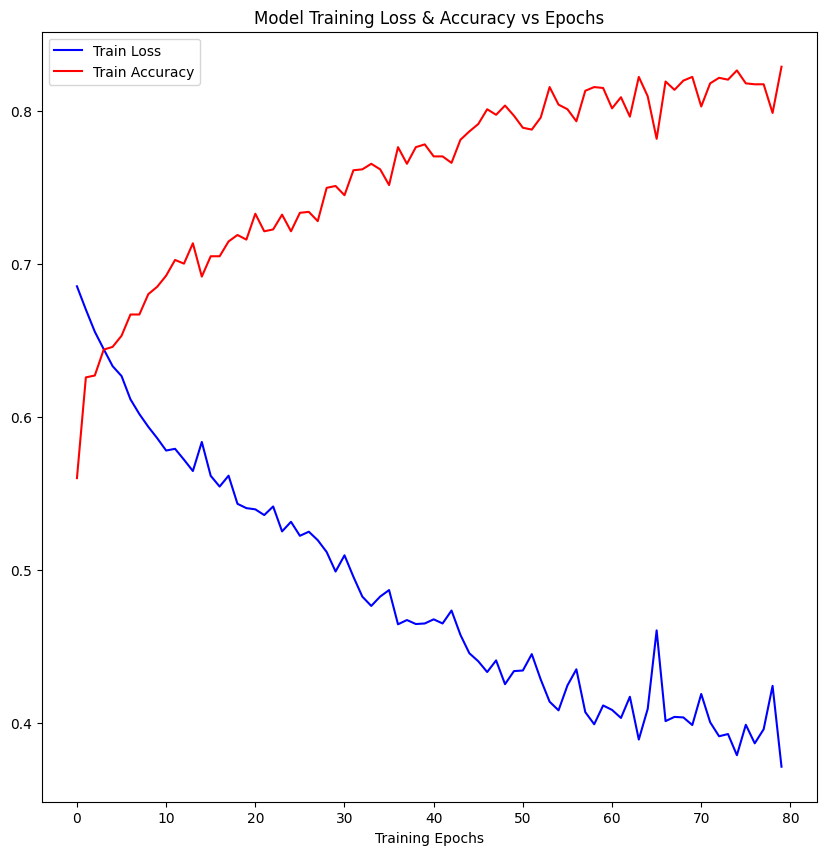

In [19]:
# Plotting Training loss vs Epochs 
def plot_curves(history): 
    
    print('\nMODEL TRAINING RESULTS\n')
    plt.figure(figsize=(10,10))
    plt.plot(history.history['loss'], color = 'blue')
    plt.plot(history.history['accuracy'], color = 'red')
    plt.title('Model Training Loss & Accuracy vs Epochs')
    plt.xlabel('Training Epochs')
    plt.legend(['Train Loss', 'Train Accuracy'], loc='best')
    plt.show()
        
plot_curves(history)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
PREDICTED SIGNAL: 

[0.43 0.43 0.49 0.79 0.91 0.81 0.79 0.79 0.84 0.83 0.81 0.82 0.8  0.83
 0.84 0.83 0.69 0.74 0.77 0.86 0.81 0.65 0.58 0.49 0.43 0.44 0.53 0.56
 0.69 0.84 0.97 0.97 0.96 0.94 0.94 0.94 0.95 0.97 0.99 1.   0.97 0.97
 0.97 0.97 0.85 0.92 0.91 0.96 0.68 0.63 0.54 0.62 0.51 0.6  0.73 0.65
 0.63 0.69 0.74 0.87 0.91 0.91 0.82 0.87 0.93 0.96 0.97 0.99 0.99 0.97
 0.91 0.94 0.99 0.99 0.99 1.   1.   1.   1.   1.   1.   1.   1.   1.
 0.95 0.95 0.96 0.97 0.97 0.97 0.96 0.86 0.97 0.48 0.57 0.48 0.69 0.61
 0.51 0.42 0.57 0.35 0.49 0.47 0.97 0.65 0.45 0.54 0.24 0.18 0.26 0.22
 0.15 0.18 0.44 0.54 0.77 0.98 0.99 1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   0.93 0.44 0.09 0.03 0.01
 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.06 0.06 0.02 0.02 0.
 0.   0.08 0.94 0.99 0.91 1.   1.   0.48 0.35 0.55 0.1  0.33 0.16 0.35
 1.   1.   1.   1.   1.   0.99 0.9  1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.  

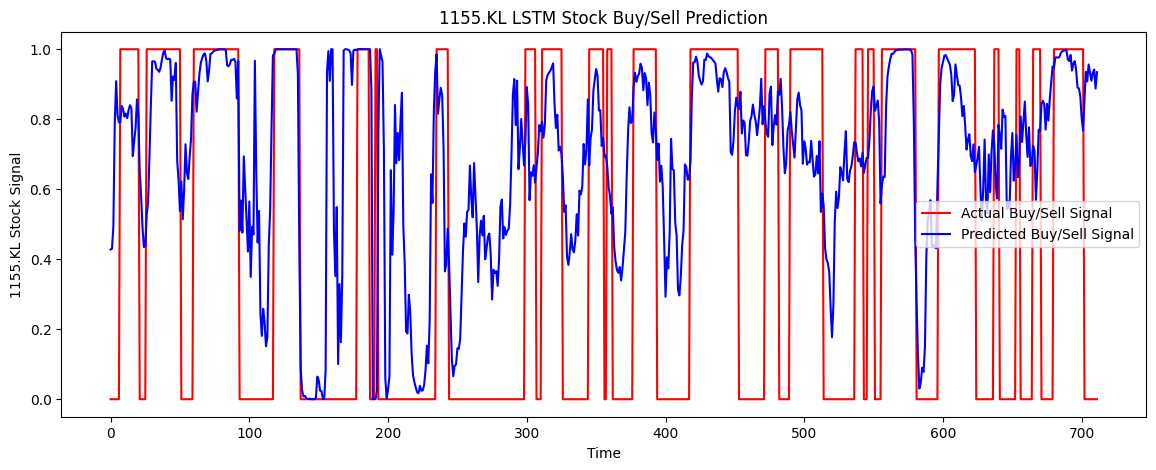

In [24]:
# Testing Initial Model 
# Printing Confusion Matrix, Classification Report, and Visualizing Predicted Signal
tf.keras.utils.plot_model(model, to_file='0162.KL-LSTM.png', show_shapes=True)
eval_model(model, X_test, y_test)